## Question 9.2

 Considere o problema das espirais. Sendo a espiral 1 uma classe e a espiral 2  outra classe. Gere as curvas das espirais  usando as seguintes equações:

 - Espiral 1: $x=\frac{\theta}{4}cos\theta$ e $y=\frac{\theta}{4}sin\theta$ para $\theta \geq 0$
 - Espiral 2: $x=(\frac{\theta}{4} + 0.8)cos\theta$ e $y=(\frac{\theta}{4} + 0.8)sin\theta$ para $\theta \geq 0$

 Solucione este  problema utilizando uma rede perceptron de múltiplas camadas. Gere apartir das equações os dados para treinamento e teste. Determine a matriz de confusão

### Importing Libraries

In [93]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### Generating Data

In [2]:
def espiral_1(theta):
    x = theta/4 * np.cos(theta)
    y = theta/4 * np.sin(theta)
    return x,y

In [4]:
def espiral_2(theta):
    x = (theta/4 + 0.8) * np.cos(theta)
    y = (theta/4 + 0.8) * np.sin(theta)
    return x,y

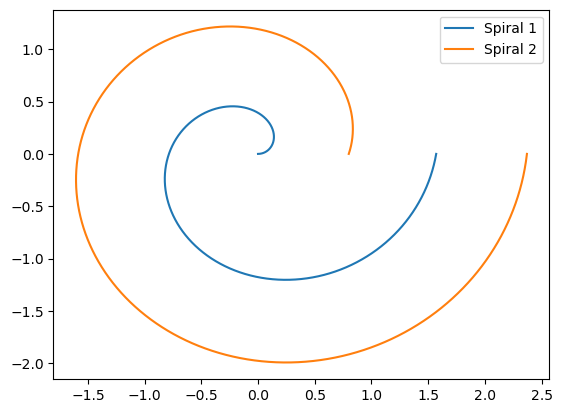

In [71]:
# generate data
theta = np.linspace(0, 2*np.pi, 10000)
x1, y1 = espiral_1(theta)
x2, y2 = espiral_2(theta)

# plot data
plt.plot(x1, y1, label='Spiral 1')
plt.plot(x2, y2, label='Spiral 2')
plt.legend()
plt.show()

In [72]:
# label the data
z1 = np.zeros_like(x1)
z2 = np.ones_like(x2)

### Train Test Split

In [73]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
z = np.concatenate([z1, z2])

In [74]:
train_x, test_x, train_y, test_y = train_test_split(np.stack([x, y], axis=1), z, 
                                                    stratify=z, shuffle=True,
                                                    test_size=0.2, random_state=42)

In [75]:
# transform to tensors
x_train = torch.tensor(train_x, dtype=torch.float32)
y_train = torch.tensor(train_y, dtype=torch.float32)
x_test = torch.tensor(test_x, dtype=torch.float32)
y_test = torch.tensor(test_y, dtype=torch.float32)

In [76]:
# create dataloaders
train_dataloader = DataLoader(
    list(zip(x_train, y_train)),
    batch_size=64,
    shuffle=True
)

test_dataloader = DataLoader(
    list(zip(x_test, y_test)),
    batch_size=64,
    shuffle=False
)

### Training

In [77]:
def get_model_9_2(device):
    model = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(2, 8)),
        ('relu1', nn.ReLU()),
        ('fc2', nn.Linear(8, 4)),
        ('relu2', nn.ReLU()),
        ('fc3', nn.Linear(4, 1)),
        ('sigmoid', nn.Sigmoid())
    ])).to(device)
    return model

In [78]:
# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create model
model_9_2 = get_model_9_2(device)

# define optimizer and loss function
optimizer = torch.optim.RMSprop(model_9_2.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [79]:
# check number of parameters
print(f'Number of parameters: {sum(p.numel() for p in model_9_2.parameters())}')

Number of parameters: 65


In [80]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=100, device=device):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            y_hat = y_hat.squeeze()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        model.eval()
        with torch.no_grad():
            for x, y in test_dataloader:
                x = x.to(device)
                y = y.to(device)
                y_hat = model(x)
                y_hat = y_hat.squeeze()
                loss = criterion(y_hat, y)
        test_loss.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}')
    return train_loss, test_loss

In [81]:
train_loss, test_loss = train(model_9_2, train_dataloader, test_dataloader, criterion, optimizer, epochs=100, device=device)

Epoch 1/100, Train Loss: 0.6775, Test Loss: 0.6680
Epoch 11/100, Train Loss: 0.5105, Test Loss: 0.5158
Epoch 21/100, Train Loss: 0.5110, Test Loss: 0.5155
Epoch 31/100, Train Loss: 0.5283, Test Loss: 0.5154
Epoch 41/100, Train Loss: 0.5153, Test Loss: 0.5153
Epoch 51/100, Train Loss: 0.5354, Test Loss: 0.5153
Epoch 61/100, Train Loss: 0.4855, Test Loss: 0.5152
Epoch 71/100, Train Loss: 0.5448, Test Loss: 0.5152
Epoch 81/100, Train Loss: 0.4737, Test Loss: 0.5151
Epoch 91/100, Train Loss: 0.5151, Test Loss: 0.5151


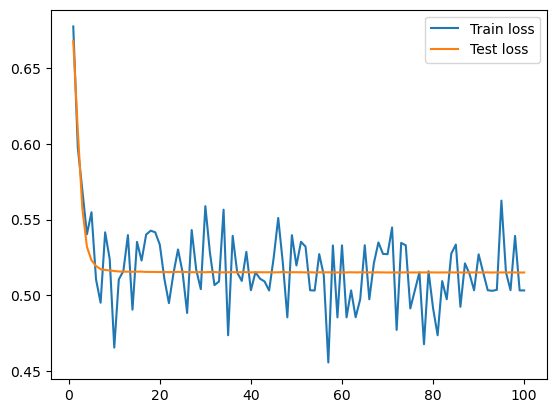

In [82]:
# plot the loss
plt.plot(np.arange(1,101), train_loss, label='Train loss')
plt.plot(np.arange(1,101), test_loss, label='Test loss')
plt.legend()
plt.show()

### Evaluating

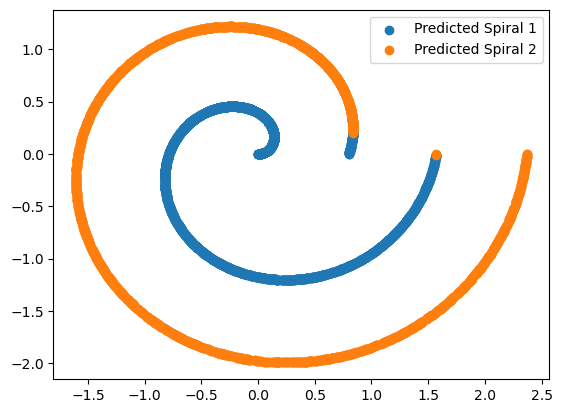

In [92]:
# plot the points predicted by the model
model_9_2.eval()
with torch.no_grad():
    y_pred = model_9_2(x_test.to(device))
    y_pred = y_pred.cpu().numpy().flatten()
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

fig, ax = plt.subplots()
# ax.plot(x1, y1, label='Spiral 1')
# ax.plot(x2, y2, label='Spiral 2')
ax.scatter(x_test[y_pred == 0, 0], x_test[y_pred == 0, 1], label='Predicted Spiral 1')
ax.scatter(x_test[y_pred == 1, 0], x_test[y_pred == 1, 1], label='Predicted Spiral 2')
ax.legend()
plt.show()

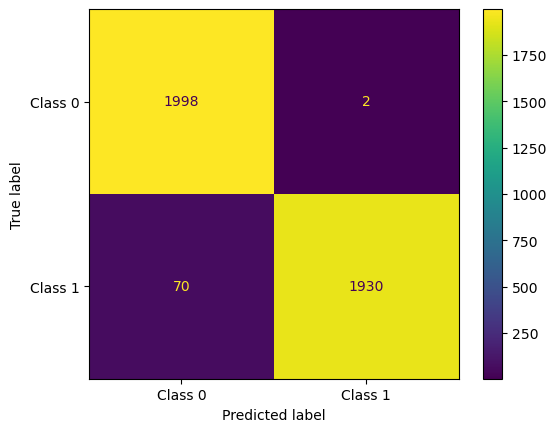

In [88]:
# plot confusion matrix\
y_pred = model_9_2(x_test.to(device)).detach().cpu().numpy()
y_pred = (y_pred > 0.5).astype(int)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Class 0', 'Class 1']).plot()

In [95]:
# plot classificarion report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98      2000
     Class 1       1.00      0.96      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000

